<a href="https://colab.research.google.com/github/tsarkov90/neural-style-transfer/blob/master/pytorch-style-transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

## Введение

Здесь показано, как с помощью **`PyTorch`** реализовать этот алгоритм, который был описан в работе [A Neural Algorithm of Artistic Style by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge](https://arxiv.org/abs/1508.06576).

*NST* позволяет вам взять изображение и воспроизвести его с новым художественным стилем. Вкратце, этот алгоритм берет на вход два изображения: контентное *(content image)* и стилевое *(style image)* и выдает вам первое изображение, которое было воспроизведено в стилистике второго

<img src='https://github.com/tsarkov90/tf-style-transfer/blob/master/content/neuralstyle.png?raw=1'>



## Принцип работы алгоритма

Принцип прост: мы определяем два расстояния, одно для контента ($D_C$) и одно для стиля ($D_S$). ($D_S$) показывает насколько сильно различается контент между двумя изображениями, а $D_S$ насколько сильно сильно отличается стиль. Затем мы берем третье изображение и преобразуем его так, чтобы свести к минимуму как его $D_С$ с изображением контента, так и его $D_S$ с изображением стиля.



## Импорт модулей и выбор оборудования

Ниже у нас список модулей и пакетов, необходимых для работы алгоритма:
*   **`torch`**, **`torch.nn`**, **`numpy`** (незаменимые пакеты для нейронных сетей с PyTorch)
*   **`torch.optim`** (тут у нас градиентный спуск)
*   **`PIL`**, **`PIL.Image`**, **`matplotlib.pyplot`** (работа с изображениями)
*   **`torchvision.transforms`** (перевод `PIL images` в `tensors`)
*   **`torchvision.models`** (обучение моделей или загрузка готовых моделей)
*   **`copy`** (глубокая копия моделей)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

In [0]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import copy
from tqdm.notebook import tqdm
from PIL import Image

Далее нам нужно выбрать, на каком устройстве запускать сеть, и импортировать изображения контента и стиля. Запуск алгоритма нейронной передачи на больших изображениях занимает больше времени и будет работать гораздо быстрее при работе на графическом процессоре. Мы можем использовать **`torch.cuda.is_available()`** для определения наличия доступного графического процессора.

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Загрузка изображений

Теперь мы импортируем изображения стиля и контента. Исходные изображения PIL имеют значения от 0 до 255, но при преобразовании в *Torch tensors* их значения преобразуются в значения от 0 до 1.

Так же необходимо изменить размеры изображений так, чтобы они совпадали.

Важная деталь, которую следует отметить, заключается в том, что нейронные сети из библиотеки **`torch`** обучаются с тензорными значениями в диапазоне от 0 до 1. Если вы попытаетесь *скормить сети* тензорные изображения со значениями от 0 до 255, то активированные карты объектов не смогут распознать предполагаемый контент и стиль. Однако предварительно обученные сети из библиотеки *Caffe* обучаются с помощью тензорных изображений от 0 до 255.




In [0]:
# желаемый размер изображения
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # масштабируем изображение
    transforms.ToTensor()])  # переводим его в torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [0]:
content_img = image_loader('/content/dancing.jpg')
style_img = image_loader('/content/picasso.jpg')

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size proportion"

Теперь давайте создадим функцию, которая отображает изображение путем повторного преобразования его копии в формат PIL и отображения копии с помощью **`plt.imshow`**. Выведем на экран *content image* и *style image*, чтобы убедиться, что мы все сделали правильно.


In [0]:
unloader = transforms.ToPILImage()  # переконвертируем в PIL image

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # мы копируем tensor, чтобы не вносить в него
                                  # никаких изменений
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    
    if title is not None:
        plt.title(title)

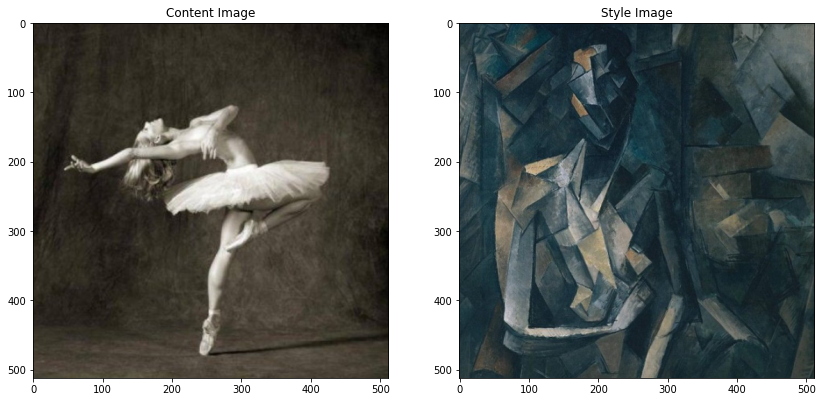

In [0]:
plt.figure(figsize=(14,10))

plt.subplot(121)
imshow(content_img, title='Content Image')

plt.subplot(122)
imshow(style_img, title='Style Image')

## Функции потерь *(Loss functions)*




### Потеря контента *(content loss)*

*Content loss* — это функция, которая представляет собой взвешенную версию контентного расстояния для отдельного слоя. 
Функция принимает карты признаков $F_{XL}$ слоя $L$ при обработке сетью изображения $X$ и возвращает взвешенное контентное расстояние $w_{CL}.D_C^L(X,C)$ между изображением $X$ и изображением контента $C$. 
Для вычисления контентного расстояния функция должна знать карты объектов изображения контента ($F_{CL}$). 

Мы реализуем эту функцию как *torch module* с конструктором, который принимает $F_{CL}$ в качестве входных данных.
Расстояние $\|F_{XL} - F_{CL}\|^2$ является среднеквадратичной ошибкой между двумя наборами карт объектов и может быть вычислено с помощью **`nn.MSELoss`**.

Мы добавим этот модуль потери контента после слоев свертки, которые используются для вычисления расстояния до содержимого.
Таким образом, каждый раз, когда в сеть подается изображение $X$, потери контента будут вычисляться на нужных слоях, и из-за автоматического градуирования *(auto grad)* будут вычисляться все градиенты. 
Теперь, чтобы сделать слой потери содержимого прозрачным, мы должны определить прямой (`forward`) метод, который вычисляет потерю контента и затем возвращает входные данные этого слоя. Вычисленная потеря сохраняется в качестве параметра модуля.

In [0]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

> **Важная деталь**: хотя этот модуль называется **`ContentLoss`**, он не *true* функцией потерь из PyTorch. Если вы хотите определить потерю контента как функцию потерь из PyTorch, вам нужно создать функцию автоградуирования из PyTorch для повторного вычисления / реализации градиента вручную в при обратном проходе.


   



### Потеря стиля *(style loss)*

Модуль потери стиля реализован аналогично модулю потери контента. 
Он будет также действовать как прозрачный слой в сети, который вычисляет потерю стиля на этом слое.
Для того, чтобы рассчитать потерю стиля, нам надо вычислить матрицу Грама $G_{XL}$.

Матрица Грама — это результат умножения заданной матрицы на её транспонированную.
Здесь эта матрицы представляет собой измененную версию карты признаков $F_{XL}$ слоя $L$.
$F_{XL}$ преобразуется в матрицу $\hat{F}_{XL}$ размерности $K$ x $N$, где $K$ — число карт признаков в слое $L$, а $N$ — длина любой векторизованной карты признаков $F_{XL}^k$.
Например, первая строка $\hat{F}_{XL}$ соответствует 1-й векторизованной карте признаков $F_{XL}^1$.

Наконец, матрица Грама нормализуется путем деления каждого элемента на общее число элементов в матрице. Такая нормализация исходит из того факта, что матрицы $\hat{F}_{XL}$ с большой разменостью $N$ не должны иметь огромныые значения, так как они приведут к тому, что первые слои (перед пулингом) будут оказывать большое влияние при градиентном спуске, что возможно приведет к ошибкам. Стилевые признаки, как правило, находятся в более глубоких слоях сети, поэтому нормализация имеет весьма большое значение.


In [0]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a = batch size(=1)
    # b = number of feature maps
    # (c, d) = dimensions of a feature map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Теперь модуль потери стиля выглядит почти точно так же, как модуль потери контента. Расстояние стиля $D_S$ также вычисляется с использованием среднеквадратичной ошибки между $G_{XL}$ и $G_{SL}$.




In [0]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Импорт модели

Теперь нам необходимо импортировать предварительно обученную нейронную сеть. Мы будем использовать **`VGG-19`**, как советуют авторы алгоритма.

Реализация **`VGG`** в PyTorch представляет собой модуль, разделенный на два **`Sequental`** модуля: **`features`** (содержит слои свёртки и пулинга) и **`classifier`** (cодержит *fully connected* слои).

Будем использовать **`features`**, так как нам нужны выходные данные для отдельных свёрточных слоёв при вычислении потери контента и потери стиля.

Некоторые слои во время обучения имеют другое поведение, поэтому при вычислении потерь, нам нужно сеть перевести в режим `evaluation` (сделать это можно при помощью **`.eval()`**)



In [0]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Кроме того, **`VGG`** обучаются на RGB изображениях (трехканальных), где каждый канал нормализован по среднему значению = [0.485, 0.456, 0.406] и стандартному отклонению =[0.229, 0.224, 0.225].

Учтём это при отправке нашего изображения в сеть.




In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Модуль **`Sequential`** содержит упорядоченный список дочерних модулей. Например, **`vgg19.features`** содержит последовательность *(Conv2d, ReLU, MaxPool2d, Conv2d, ReLU...)*, выровненную в правильном порядке глубины.

Нам нужно добавить наши слои потери контента и потери стиля сразу же после слоя свертки, который они обнаруживают. Для этого мы должны создать новый модуль **`Sequential`**, в который будут правильно вставлены модули потери контента и потери стиля.




In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn,
                               normalization_mean,
                               normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean,
                                  normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)

        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)

            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Далее мы выбираем входное изображение $X$. Можно использовать копию изображения контента или просто белый шум.




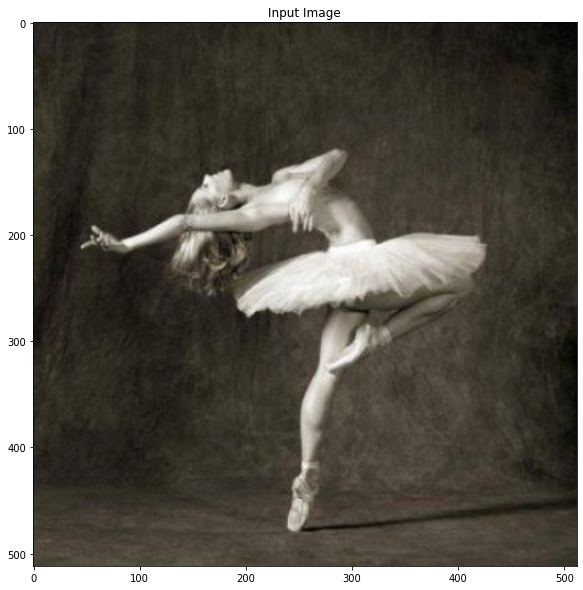

In [0]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure(figsize=(10,10))
imshow(input_img, title='Input Image')

## Градиентный спуск

В оригинальном алгоритме используется алгоритм *L-BFGS* для градиентного спуска.
В отличие от обучения сети, мы хотим обучить входное изображение, чтобы минимизировать потери контента и стиля.

Создадим *PyTorch L-BFGS optimizer* **`optim.LBFGS`** и передадим ему наше изображение в виде тензора.





In [0]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

Наконец, мы должны определить функцию, которая выполняет NST. Для каждой итерации он получает обновленные входные данные и вычисляет новые потери. Мы запустим обратные *(backward)* методы каждого модуля потерь, чтобы динамически вычислить их градиенты. Оптимизатору требуется функция "закрытия", которая переоценивает модуль и возвращает потерю.

Возникает еще одна проблема. Сеть может попытаться оптимизировать входные данные со значениями, которые превышают диапазон от 0 до 1 для изображения. Мы можем решить эту проблему, исправляя входные значения на диапазон от 0 до 1 при каждом запуске итерации.



In [0]:
def run_style_transfer(cnn,
                       normalization_mean,
                       normalization_std,
                       content_img, style_img,
                       input_img,
                       style_weight=1000000,
                       content_weight=1,
                       epochs = 10,
                       epoch_steps = 50):
    """
    Run the style transfer.
    """
    print('Building the style transfer model..')
    
    (model, 
     style_losses, 
     content_losses) = get_style_model_and_losses(cnn,
                                                  normalization_mean,
                                                  normalization_std,
                                                  style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= epoch_steps * epochs:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            style_score = sum([sl.loss for sl in style_losses])
            content_score = sum([cl.loss for cl in content_losses])

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % epoch_steps == 0:
                display.clear_output(wait=True)
                print(f"After step {run}:")
                # print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                #     style_score.item(), content_score.item()))
                # print()
                plt.figure()
                imshow(input_img, title=f"After step {run}:")
                plt.show()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Запускаем сеть в работу




After step [500]:


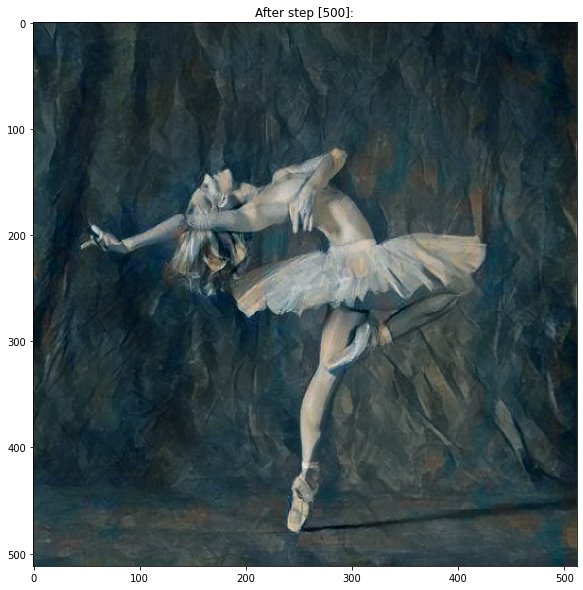

In [0]:
output = run_style_transfer(cnn,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_img, style_img,
                            input_img)

Сохраняем наше изображение

In [0]:
def save_image(image_tensor, filename='stylized-image.png'):
    image = unloader(image_tensor.cpu().squeeze(0))
    image.save(filename)

    try:
        from google.colab import files
    except ImportError:
        pass
    else:
        files.download(file_name)


In [0]:
save_image(output)

## Повторное использование

In [0]:
content_img = image_loader('/content/YellowLabradorLooking_new.jpg')
style_img = image_loader('/content/Vassily_Kandinsky,_1913_-_Composition_7.jpg')

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size proportion"

In [0]:
plt.figure(figsize=(14,10))

plt.subplot(121)
imshow(content_img, title='Content Image')

plt.subplot(122)
imshow(style_img, title='Style Image')

In [0]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure(figsize=(10,10))
imshow(input_img, title='Input Image')

In [0]:
output = run_style_transfer(cnn,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_img, style_img,
                            input_img)

## Показательные выступления






### Балерина

<img src='/content/dancing_sc.png'>
<img src='/content/dancing_gif.gif'>

### Собака

<img src='/content/doge_sc.png'>
<img src='/content/doge_gif.gif'>

### Черепаха

<img src='/content/turtle_sc.png'>
<img src='/content/turtle_gif.gif'>